### Data Dictionary

We will be looking at nutritional data of over 7,000
foods distributed by the US Department of Agricultural.

Predict Calories of food

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance,plot_tree

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("USDA.csv")

In [3]:
df

,ID,Description,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
0,1001,"BUTTER,WITH SALT",717.0,0.85,81.11,0.06,714.0,51.368,215.0,0.06,24.0,0.02,24.0,0.0,2.32,1.5
1,1002,"BUTTER,WHIPPED,WITH SALT",717.0,0.85,81.11,0.06,827.0,50.489,219.0,0.06,24.0,0.16,26.0,0.0,2.32,1.5
2,1003,"BUTTER OIL,ANHYDROUS",876.0,0.28,99.48,0.00,2.0,61.924,256.0,0.00,4.0,0.00,5.0,0.0,2.80,1.8
3,1004,"CHEESE,BLUE",353.0,21.40,28.74,2.34,1395.0,18.669,75.0,0.50,528.0,0.31,256.0,0.0,0.25,0.5
4,1005,"CHEESE,BRICK",371.0,23.24,29.68,2.79,560.0,18.764,94.0,0.51,674.0,0.43,136.0,0.0,0.26,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7053,80200,"FROG LEGS,RAW",73.0,16.40,0.30,0.00,58.0,0.076,50.0,0.00,18.0,1.50,285.0,0.0,1.00,0.2
7054,83110,"MACKEREL,SALTED",305.0,18.50,25.10,0.00,4450.0,7.148,95.0,0.00,66.0,1.40,520.0,0.0,2.38,25.2
7055,90240,"SCALLOP,(BAY&SEA),CKD,STMD",111.0,20.54,0.84,5.41,667.0,0.218,41.0,0.00,10.0,0.58,314.0,0.0,0.00,0.0
7056,90560,"SNAIL,RAW",90.0,16.10,1.40,2.00,70.0,0.361,50.0,0.00,10.0,3.50,382.0,0.0,5.00,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7058 entries, 0 to 7057
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            7058 non-null   int64  
 1   Description   7058 non-null   object 
 2   Calories      7057 non-null   float64
 3   Protein       7057 non-null   float64
 4   TotalFat      7057 non-null   float64
 5   Carbohydrate  7057 non-null   float64
 6   Sodium        6974 non-null   float64
 7   SaturatedFat  6757 non-null   float64
 8   Cholesterol   6770 non-null   float64
 9   Sugar         5148 non-null   float64
 10  Calcium       6922 non-null   float64
 11  Iron          6935 non-null   float64
 12  Potassium     6649 non-null   float64
 13  VitaminC      6726 non-null   float64
 14  VitaminE      4338 non-null   float64
 15  VitaminD      4224 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 882.4+ KB


In [5]:
df.describe(include='all')

,ID,Description,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
count,7058.000000,7058,7057.000000,7057.000000,7057.000000,7057.000000,6974.000000,6757.000000,6770.000000,5148.000000,6922.000000,6935.000000,6649.000000,6726.000000,4338.000000,4224.000000
unique,NaN,7054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,"OIL,INDUSTRIAL,PALM KERNEL (HYDROGENATED),CONF...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,14259.821196,NaN,219.695338,11.710368,10.320614,20.697860,322.059220,3.452267,41.551994,8.256540,73.530627,2.828368,301.357949,9.435980,1.487462,0.576918
std,8577.179705,NaN,172.198755,10.919356,16.814191,27.630443,1045.416931,6.921267,122.963028,15.361509,222.445338,6.019878,415.638949,71.256536,5.386914,4.301147
min,1001.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8387.250000,NaN,85.000000,2.290000,0.720000,0.000000,37.000000,0.172000,0.000000,0.000000,9.000000,0.520000,135.000000,0.000000,0.120000,0.000000
50%,13293.500000,NaN,181.000000,8.200000,4.370000,7.130000,79.000000,1.256000,3.000000,1.395000,19.000000,1.330000,250.000000,0.000000,0.270000,0.000000
75%,18336.750000,NaN,331.000000,20.430000,12.700000,28.170000,386.000000,4.028000,69.000000,7.875000,56.000000,2.620000,348.000000,3.100000,0.710000,0.100000


In [6]:
df.shape

(7058, 16)

In [7]:
df.columns

Index(['ID', 'Description', 'Calories', 'Protein', 'TotalFat', 'Carbohydrate',
       'Sodium', 'SaturatedFat', 'Cholesterol', 'Sugar', 'Calcium', 'Iron',
       'Potassium', 'VitaminC', 'VitaminE', 'VitaminD'],
      dtype='object')

### Data Visualization

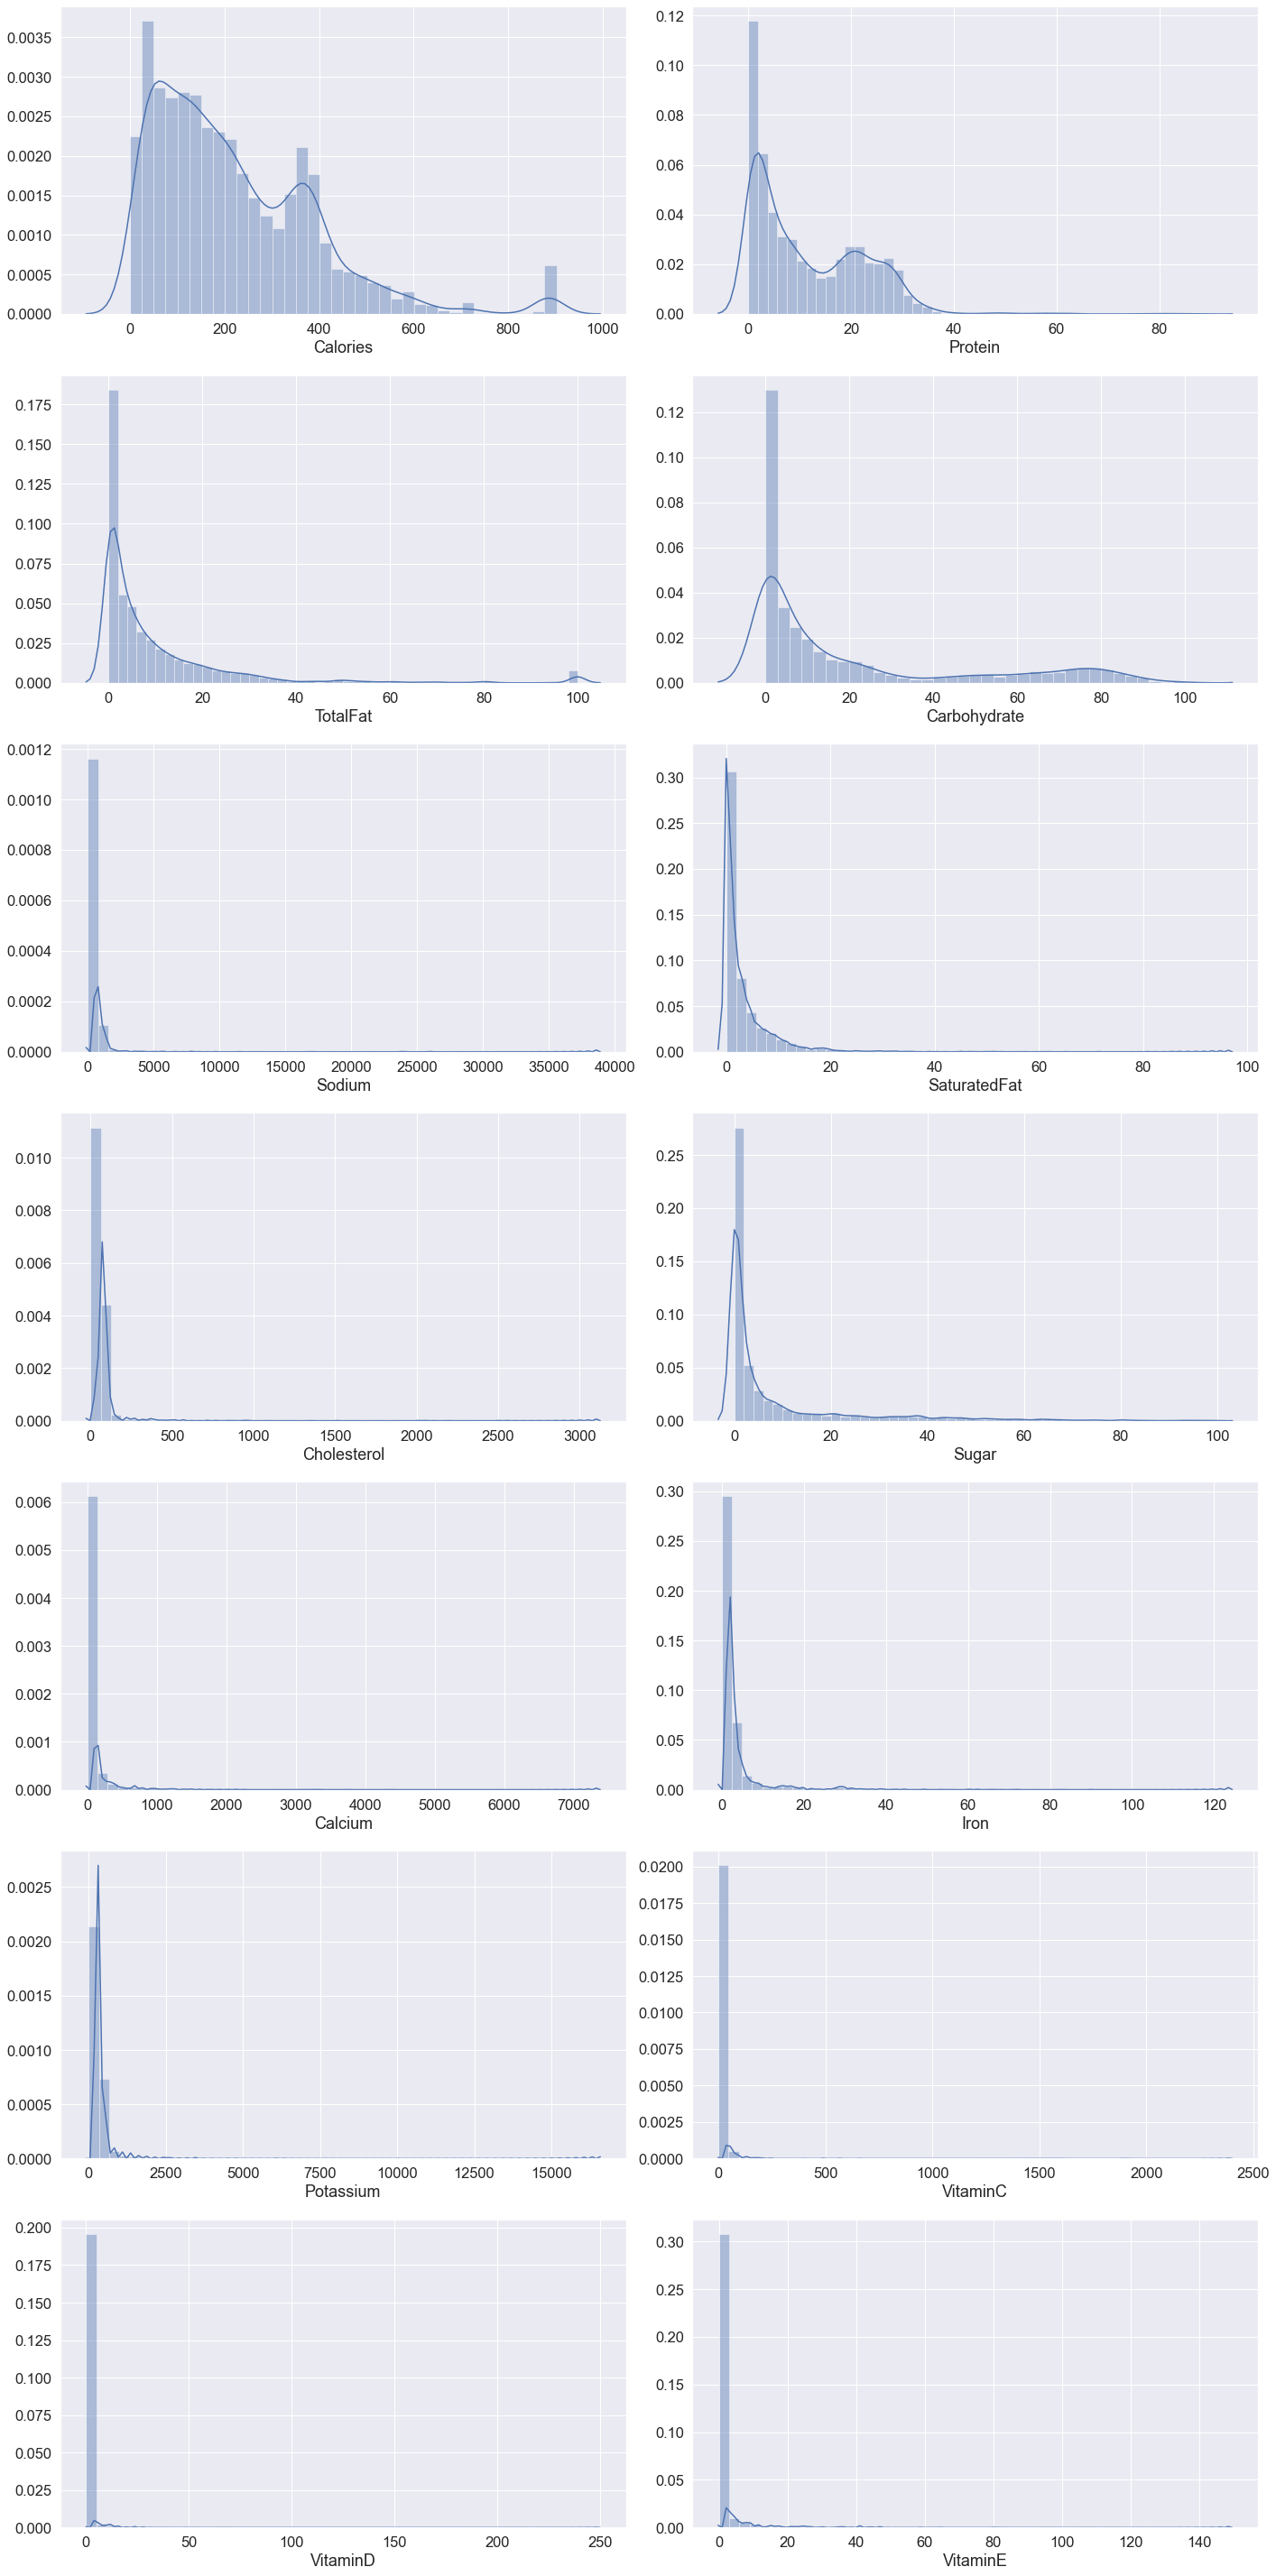

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.Calories)
plt.subplot(7,2,2)
sns.distplot(df.Protein)
plt.subplot(7,2,3)
sns.distplot(df.TotalFat)
plt.subplot(7,2,4)
sns.distplot(df.Carbohydrate)
plt.subplot(7,2,5)
sns.distplot(df.Sodium)
plt.subplot(7,2,6)
sns.distplot(df.SaturatedFat)
plt.subplot(7,2,7)
sns.distplot(df.Cholesterol)
plt.subplot(7,2,8)
sns.distplot(df.Sugar)
plt.subplot(7,2,9)
sns.distplot(df.Calcium)
plt.subplot(7,2,10)
sns.distplot(df.Iron)
plt.subplot(7,2,11)
sns.distplot(df.Potassium)
plt.subplot(7,2,12)
sns.distplot(df.VitaminC)
plt.subplot(7,2,13)
sns.distplot(df.VitaminD)
plt.subplot(7,2,14)
sns.distplot(df.VitaminE)

plt.tight_layout()
plt.show()

In [9]:
df.corr()

,ID,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
ID,1.000000,0.052325,0.096839,-0.061211,0.121758,-0.034822,-0.069872,-0.030098,0.074157,-0.036164,-0.047206,0.015917,0.003210,-0.062340,-0.036581
Calories,0.052325,1.000000,0.135258,0.807770,0.434701,0.033703,0.611601,0.032433,0.309989,0.112560,0.192506,0.078807,-0.029628,0.365777,0.095231
Protein,0.096839,0.135258,1.000000,0.061682,-0.284500,-0.003253,0.045784,0.280578,-0.289221,0.041071,0.133609,0.225451,-0.067523,-0.057482,0.035705
TotalFat,-0.061211,0.807770,0.061682,1.000000,-0.109399,0.003390,0.766142,0.097111,-0.055459,0.006585,-0.051781,-0.052801,-0.059612,0.370318,0.100754
Carbohydrate,0.121758,0.434701,-0.284500,-0.109399,1.000000,0.049544,-0.108676,-0.216070,0.688422,0.187122,0.362023,0.148615,0.093021,0.097550,-0.002758
Sodium,-0.034822,0.033703,-0.003253,0.003390,0.049544,1.000000,-0.005075,-0.018348,-0.007078,0.174784,0.027904,-0.009881,-0.013911,-0.002742,0.010261
SaturatedFat,-0.069872,0.611601,0.045784,0.766142,-0.108676,-0.005075,1.000000,0.096021,0.007981,0.024601,-0.068871,-0.068748,-0.046903,0.138286,0.062197
Cholesterol,-0.030098,0.032433,0.280578,0.097111,-0.216070,-0.018348,0.096021,1.000000,-0.165460,-0.033076,0.006832,-0.018960,-0.027659,-0.055091,0.153185
Sugar,0.074157,0.309989,-0.289221,-0.055459,0.688422,-0.007078,0.007981,-0.165460,1.000000,0.105687,0.119691,0.024143,0.054862,0.035455,0.043342
Calcium,-0.036164,0.112560,0.041071,0.006585,0.187122,0.174784,0.024601,-0.033076,0.105687,1.000000,0.323955,0.246256,0.128239,0.121751,0.031684


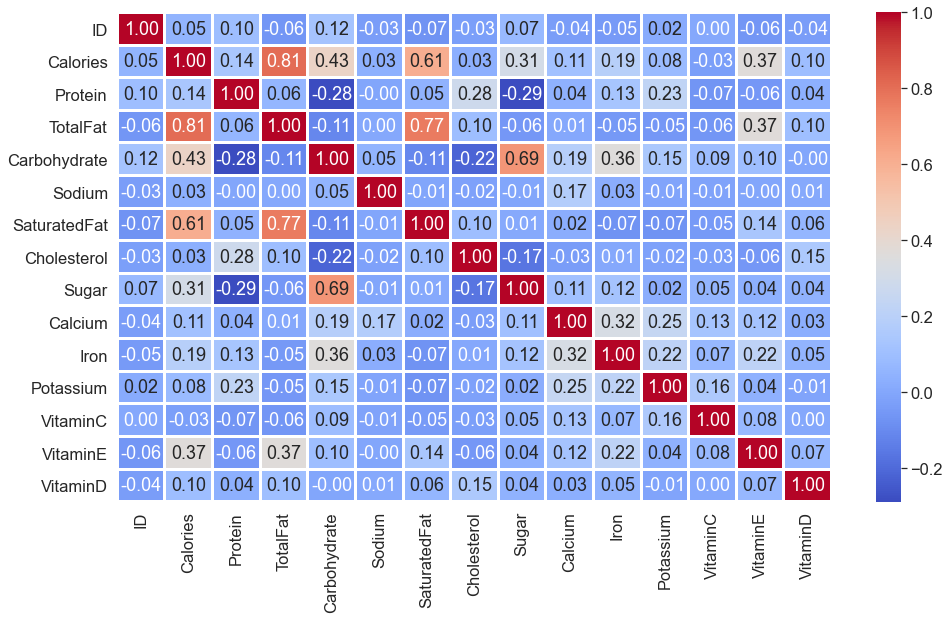

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

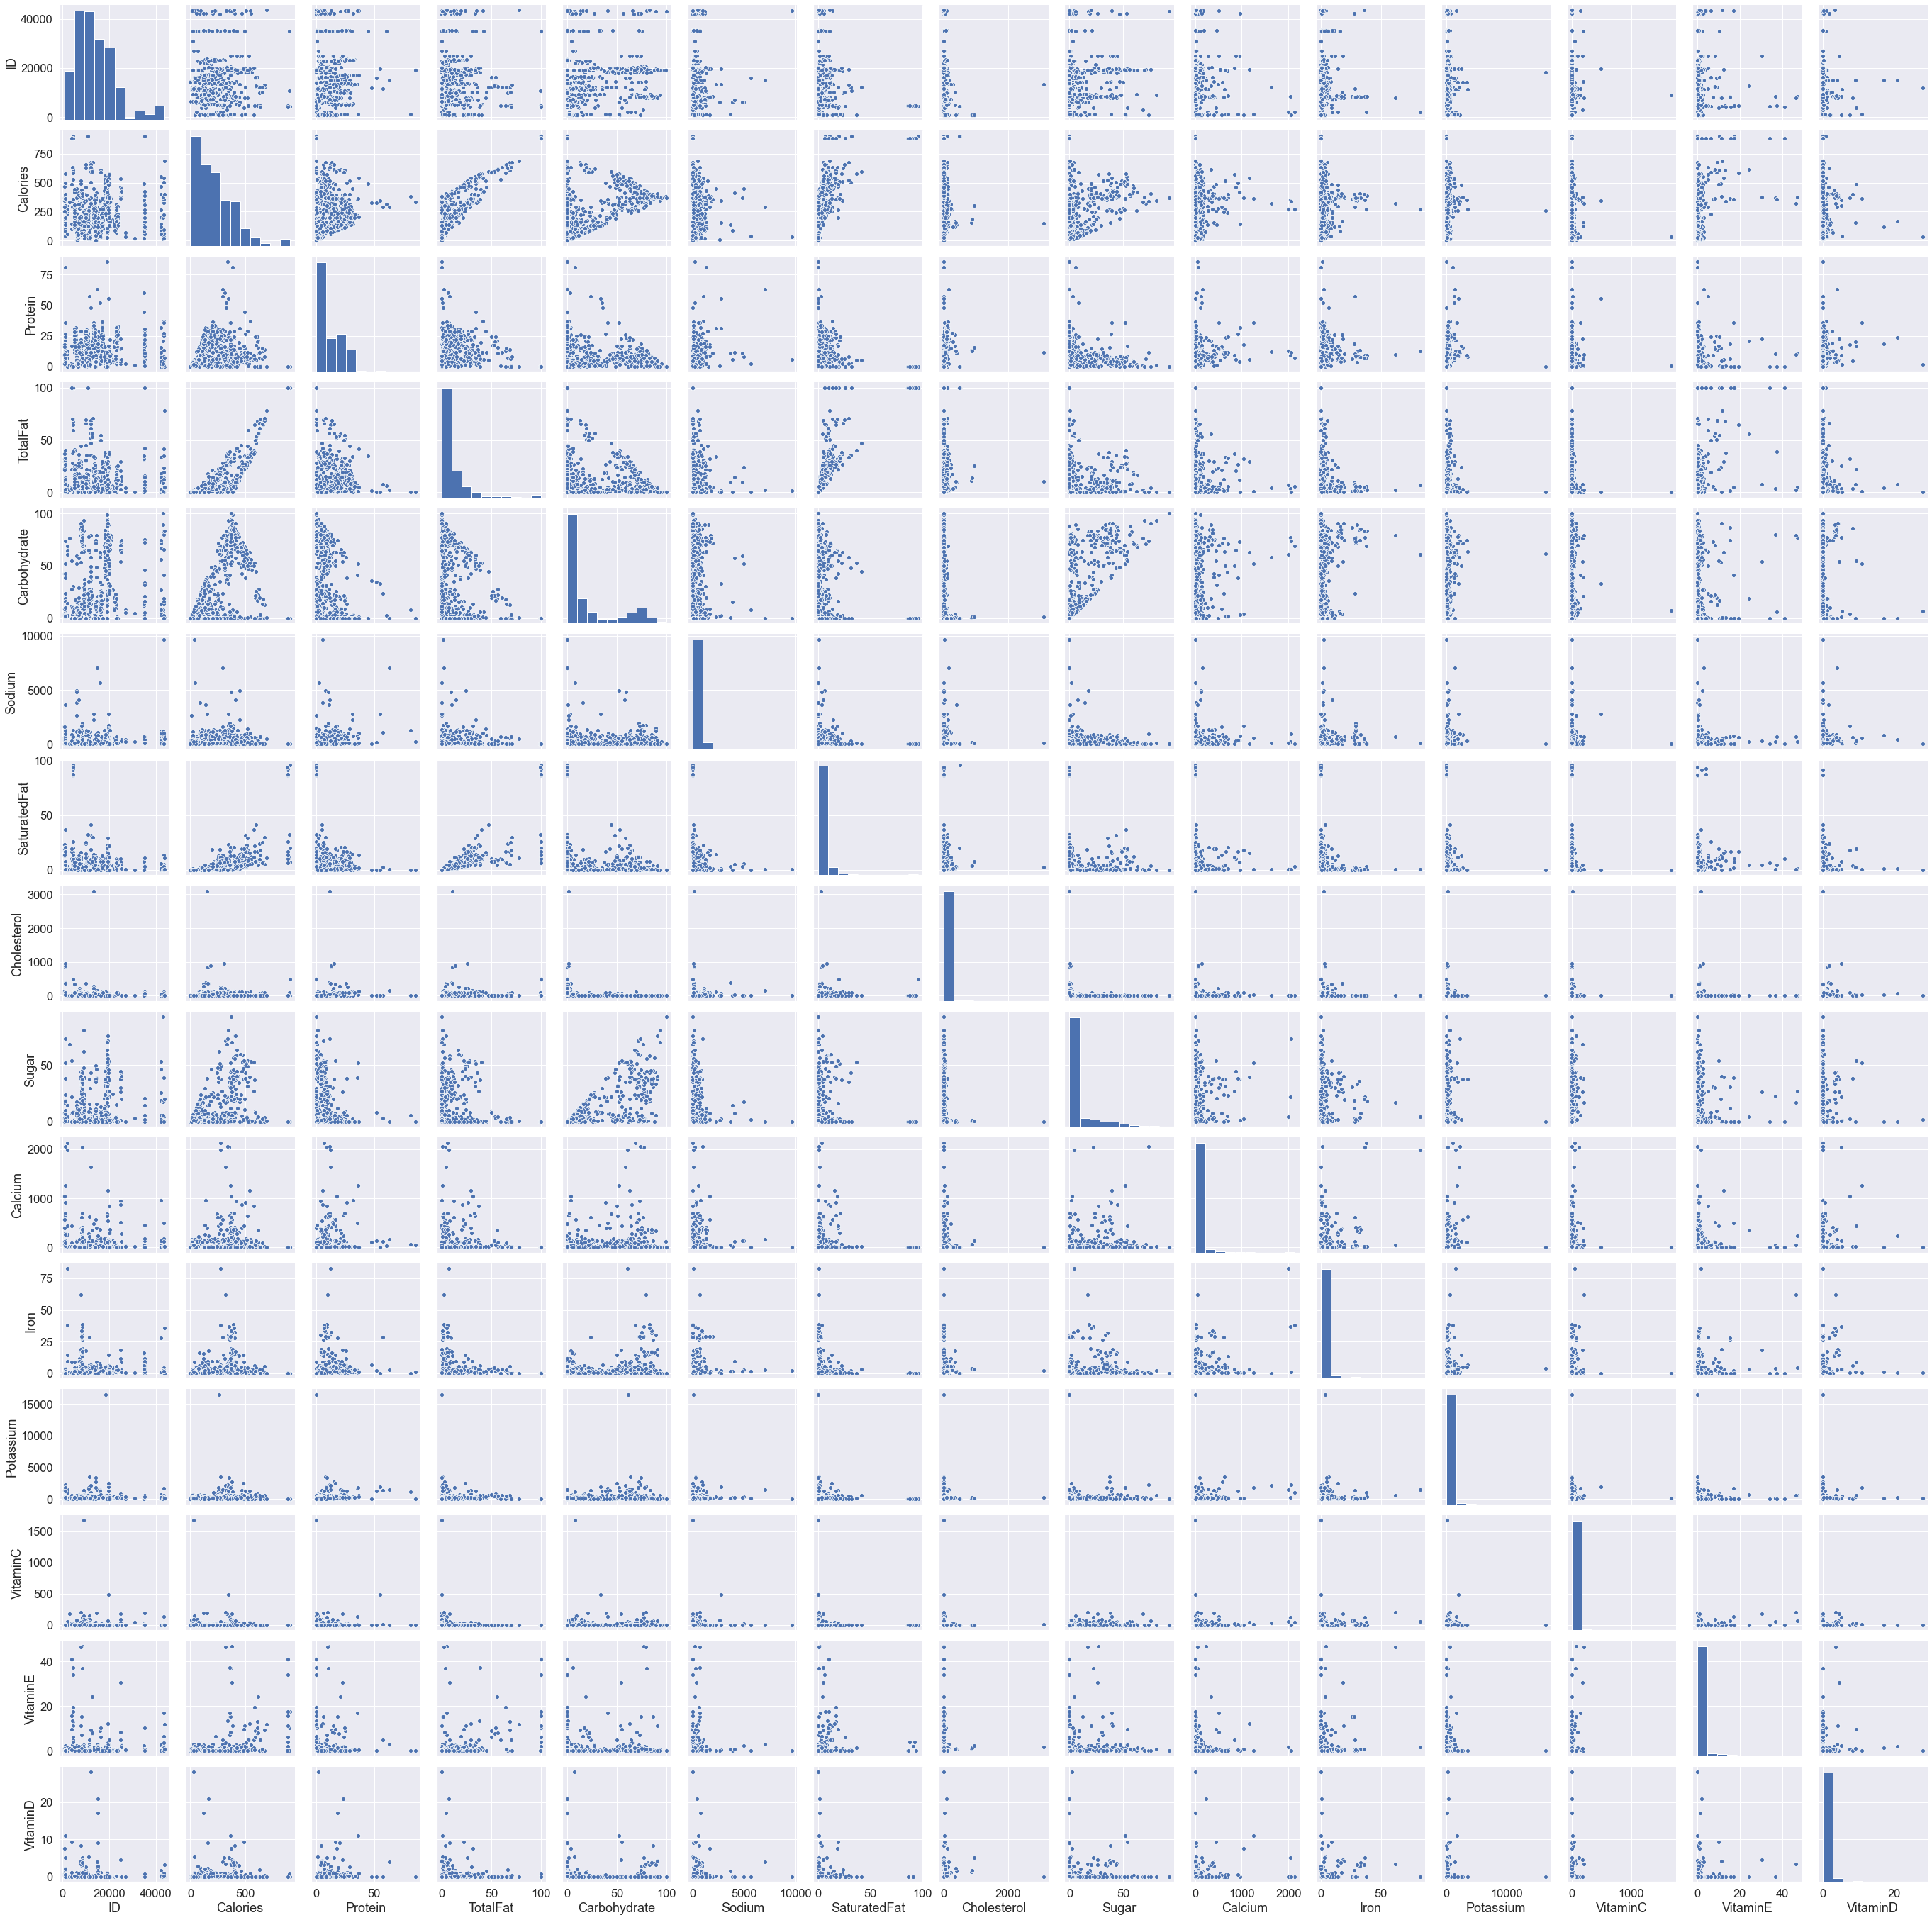

In [11]:
sns.pairplot(df.sample(1000))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

ID                 0
Description        0
Calories           1
Protein            1
TotalFat           1
Carbohydrate       1
Sodium            84
SaturatedFat     301
Cholesterol      288
Sugar           1910
Calcium          136
Iron             123
Potassium        409
VitaminC         332
VitaminE        2720
VitaminD        2834
dtype: int64

In [13]:
imputer = mdi.MeanMedianImputer(imputation_method='median',variables=None)

In [14]:
imputer.fit(df)

MeanMedianImputer(imputation_method='median',
                  variables=['ID', 'Calories', 'Protein', 'TotalFat',
                             'Carbohydrate', 'Sodium', 'SaturatedFat',
                             'Cholesterol', 'Sugar', 'Calcium', 'Iron',
                             'Potassium', 'VitaminC', 'VitaminE', 'VitaminD'])

In [15]:
df = imputer.transform(df)

In [16]:
df.isnull().sum()

ID              0
Description     0
Calories        0
Protein         0
TotalFat        0
Carbohydrate    0
Sodium          0
SaturatedFat    0
Cholesterol     0
Sugar           0
Calcium         0
Iron            0
Potassium       0
VitaminC        0
VitaminE        0
VitaminD        0
dtype: int64

### Treat Duplicate Values

In [17]:
df.duplicated(keep='first').sum()

0

### Treat Imbalance Data

### Treat Outliers

In [18]:
df.columns

Index(['ID', 'Description', 'Calories', 'Protein', 'TotalFat', 'Carbohydrate',
       'Sodium', 'SaturatedFat', 'Cholesterol', 'Sugar', 'Calcium', 'Iron',
       'Potassium', 'VitaminC', 'VitaminE', 'VitaminD'],
      dtype='object')

In [19]:
df.describe()

,ID,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
count,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000
mean,14259.821196,219.689855,11.709871,10.319770,20.695938,319.166478,3.358604,39.978889,6.399705,72.479881,2.802256,298.381836,8.992122,1.018279,0.345268
std,8577.179705,172.187170,10.918662,16.813149,27.628958,1039.510735,6.786580,120.669112,13.468575,220.418992,5.970407,403.593117,69.588883,4.264406,3.339244
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8387.250000,85.000000,2.292500,0.722500,0.000000,38.000000,0.200000,0.000000,0.200000,10.000000,0.540000,141.000000,0.000000,0.210000,0.000000
50%,13293.500000,181.000000,8.200000,4.370000,7.130000,79.000000,1.256000,3.000000,1.395000,19.000000,1.330000,250.000000,0.000000,0.270000,0.000000
75%,18336.750000,331.000000,20.427500,12.697500,28.170000,383.000000,3.812250,68.000000,4.077500,54.000000,2.587500,341.000000,2.800000,0.380000,0.000000
max,93600.000000,902.000000,88.320000,100.000000,100.000000,38758.000000,95.600000,3100.000000,99.800000,7364.000000,123.600000,16500.000000,2400.000000,149.400000,250.000000


In [20]:
windsorizer = Winsorizer(distribution='skewed',tail='both',fold=3,
                         variables=['Calories', 'Protein', 'TotalFat', 'Carbohydrate',
       'Sodium', 'SaturatedFat', 'Cholesterol', 'Sugar', 'Calcium', 'Iron',
       'Potassium', 'VitaminC', 'VitaminE', 'VitaminD'])

In [21]:
windsorizer.fit(df)

Winsorizer(distribution='skewed', fold=3, tail='both',
           variables=['Calories', 'Protein', 'TotalFat', 'Carbohydrate',
                      'Sodium', 'SaturatedFat', 'Cholesterol', 'Sugar',
                      'Calcium', 'Iron', 'Potassium', 'VitaminC', 'VitaminE',
                      'VitaminD'])

In [22]:
df2 = windsorizer.transform(df)

In [23]:
df2

,ID,Description,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
0,1001,"BUTTER,WITH SALT",717.0,0.85,48.6225,0.06,714.0,14.649,215.0,0.06,24.0,0.02,24.0,0.0,0.89,0.0
1,1002,"BUTTER,WHIPPED,WITH SALT",717.0,0.85,48.6225,0.06,827.0,14.649,219.0,0.06,24.0,0.16,26.0,0.0,0.89,0.0
2,1003,"BUTTER OIL,ANHYDROUS",876.0,0.28,48.6225,0.00,2.0,14.649,256.0,0.00,4.0,0.00,5.0,0.0,0.89,0.0
3,1004,"CHEESE,BLUE",353.0,21.40,28.7400,2.34,1395.0,14.649,75.0,0.50,186.0,0.31,256.0,0.0,0.25,0.0
4,1005,"CHEESE,BRICK",371.0,23.24,29.6800,2.79,560.0,14.649,94.0,0.51,186.0,0.43,136.0,0.0,0.26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7053,80200,"FROG LEGS,RAW",73.0,16.40,0.3000,0.00,58.0,0.076,50.0,0.00,18.0,1.50,285.0,0.0,0.89,0.0
7054,83110,"MACKEREL,SALTED",305.0,18.50,25.1000,0.00,1418.0,7.148,95.0,0.00,66.0,1.40,520.0,0.0,0.89,0.0
7055,90240,"SCALLOP,(BAY&SEA),CKD,STMD",111.0,20.54,0.8400,5.41,667.0,0.218,41.0,0.00,10.0,0.58,314.0,0.0,0.00,0.0
7056,90560,"SNAIL,RAW",90.0,16.10,1.4000,2.00,70.0,0.361,50.0,0.00,10.0,3.50,382.0,0.0,0.89,0.0


In [24]:
df2.describe()

,ID,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
count,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.0
mean,14259.821196,219.689855,11.697614,9.181517,20.695938,263.396571,2.864553,33.726693,3.723454,44.747946,2.042628,270.618731,2.441556,0.342666,0.0
std,8577.179705,172.187170,10.842162,12.020569,27.628958,346.937473,3.815734,50.360716,5.265435,54.626835,2.227924,192.671475,4.124345,0.259169,0.0
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,8387.250000,85.000000,2.292500,0.722500,0.000000,38.000000,0.200000,0.000000,0.200000,10.000000,0.540000,141.000000,0.000000,0.210000,0.0
50%,13293.500000,181.000000,8.200000,4.370000,7.130000,79.000000,1.256000,3.000000,1.395000,19.000000,1.330000,250.000000,0.000000,0.270000,0.0
75%,18336.750000,331.000000,20.427500,12.697500,28.170000,383.000000,3.812250,68.000000,4.077500,54.000000,2.587500,341.000000,2.800000,0.380000,0.0
max,93600.000000,902.000000,74.832500,48.622500,100.000000,1418.000000,14.649000,272.000000,15.710000,186.000000,8.730000,941.000000,11.200000,0.890000,0.0


In [25]:
windsorizer.left_tail_caps_

{'Calories': -653.0,
 'Protein': -52.112500000000004,
 'TotalFat': -35.2025,
 'Carbohydrate': -84.51,
 'Sodium': -997.0,
 'SaturatedFat': -10.636750000000001,
 'Cholesterol': -204.0,
 'Sugar': -11.432500000000001,
 'Calcium': -122.0,
 'Iron': -5.6025,
 'Potassium': -459.0,
 'VitaminC': -8.399999999999999,
 'VitaminE': -0.30000000000000004,
 'VitaminD': 0.0}

In [26]:
windsorizer.right_tail_caps_

{'Calories': 1069.0,
 'Protein': 74.83250000000001,
 'TotalFat': 48.622499999999995,
 'Carbohydrate': 112.68,
 'Sodium': 1418.0,
 'SaturatedFat': 14.649000000000001,
 'Cholesterol': 272.0,
 'Sugar': 15.71,
 'Calcium': 186.0,
 'Iron': 8.73,
 'Potassium': 941.0,
 'VitaminC': 11.2,
 'VitaminE': 0.89,
 'VitaminD': 0.0}

### Treat Data Types

### Feature Scaling

In [27]:
df2.columns

Index(['ID', 'Description', 'Calories', 'Protein', 'TotalFat', 'Carbohydrate',
       'Sodium', 'SaturatedFat', 'Cholesterol', 'Sugar', 'Calcium', 'Iron',
       'Potassium', 'VitaminC', 'VitaminE', 'VitaminD'],
      dtype='object')

In [28]:
df2.drop(['ID', 'Description'],axis=1,inplace=True)

In [29]:
df2.head()

,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
0,717.0,0.85,48.6225,0.06,714.0,14.649,215.0,0.06,24.0,0.02,24.0,0.0,0.89,0.0
1,717.0,0.85,48.6225,0.06,827.0,14.649,219.0,0.06,24.0,0.16,26.0,0.0,0.89,0.0
2,876.0,0.28,48.6225,0.00,2.0,14.649,256.0,0.00,4.0,0.00,5.0,0.0,0.89,0.0
3,353.0,21.40,28.7400,2.34,1395.0,14.649,75.0,0.50,186.0,0.31,256.0,0.0,0.25,0.0
4,371.0,23.24,29.6800,2.79,560.0,14.649,94.0,0.51,186.0,0.43,136.0,0.0,0.26,0.0


In [30]:
df2 = df2[['Protein', 'TotalFat', 'Carbohydrate','Sodium', 'SaturatedFat', 'Cholesterol', 'Sugar', 'Calcium', 
           'Iron','Potassium', 'VitaminC', 'VitaminE', 'VitaminD','Calories']]

In [31]:
df2.head()

,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD,Calories
0,0.85,48.6225,0.06,714.0,14.649,215.0,0.06,24.0,0.02,24.0,0.0,0.89,0.0,717.0
1,0.85,48.6225,0.06,827.0,14.649,219.0,0.06,24.0,0.16,26.0,0.0,0.89,0.0,717.0
2,0.28,48.6225,0.00,2.0,14.649,256.0,0.00,4.0,0.00,5.0,0.0,0.89,0.0,876.0
3,21.40,28.7400,2.34,1395.0,14.649,75.0,0.50,186.0,0.31,256.0,0.0,0.25,0.0,353.0
4,23.24,29.6800,2.79,560.0,14.649,94.0,0.51,186.0,0.43,136.0,0.0,0.26,0.0,371.0


In [32]:
X = df2.drop(['Calories'],axis=1)

In [33]:
X.head()

,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
0,0.85,48.6225,0.06,714.0,14.649,215.0,0.06,24.0,0.02,24.0,0.0,0.89,0.0
1,0.85,48.6225,0.06,827.0,14.649,219.0,0.06,24.0,0.16,26.0,0.0,0.89,0.0
2,0.28,48.6225,0.00,2.0,14.649,256.0,0.00,4.0,0.00,5.0,0.0,0.89,0.0
3,21.40,28.7400,2.34,1395.0,14.649,75.0,0.50,186.0,0.31,256.0,0.0,0.25,0.0
4,23.24,29.6800,2.79,560.0,14.649,94.0,0.51,186.0,0.43,136.0,0.0,0.26,0.0


In [34]:
scaler = StandardScaler()

In [35]:
X_scaled = scaler.fit_transform(X)

In [36]:
X_scaled

array([[-1.00057376,  3.28135701, -0.74694819, ..., -0.59202816,
         2.11203242,  0.        ],
       [-1.00057376,  3.28135701, -0.74694819, ..., -0.59202816,
         2.11203242,  0.        ],
       [-1.05315003,  3.28135701, -0.74911998, ..., -0.59202816,
         2.11203242,  0.        ],
       ...,
       [ 0.8156134 , -0.69398618, -0.55329706, ..., -0.59202816,
        -1.32227003,  0.        ],
       [ 0.40607196, -0.64739606, -0.67672704, ..., -0.59202816,
         2.11203242,  0.        ],
       [ 0.74735649, -0.72227303, -0.74911998, ..., -0.59202816,
         0.60711337,  0.        ]])

In [37]:
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [38]:
X_scaled

,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
0,-1.000574,3.281357,-0.746948,1.298895,3.088601,3.599753,-0.695805,-0.379839,-0.907918,-1.280087,-0.592028,2.112032,0.0
1,-1.000574,3.281357,-0.746948,1.624625,3.088601,3.679186,-0.695805,-0.379839,-0.845075,-1.269706,-0.592028,2.112032,0.0
2,-1.053150,3.281357,-0.749120,-0.753493,3.088601,4.413938,-0.707200,-0.745986,-0.916895,-1.378707,-0.592028,2.112032,0.0
3,0.894939,1.627200,-0.664420,3.261924,3.088601,0.819612,-0.612235,2.585946,-0.777742,-0.075879,-0.592028,-0.357578,0.0
4,1.064659,1.705405,-0.648132,0.854980,3.088601,1.196917,-0.610335,2.585946,-0.723877,-0.698745,-0.592028,-0.318991,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7053,0.433744,-0.738912,-0.749120,-0.592070,-0.730855,0.323158,-0.707200,-0.489683,-0.243575,0.074647,-0.592028,2.112032,0.0
7054,0.627446,1.324364,-0.749120,3.328223,1.122654,1.216775,-0.707200,0.389068,-0.288463,1.294426,-0.592028,2.112032,0.0
7055,0.815613,-0.693986,-0.553297,1.163414,-0.693638,0.144434,-0.707200,-0.636142,-0.656545,0.225173,-0.592028,-1.322270,0.0
7056,0.406072,-0.647396,-0.676727,-0.557479,-0.656159,0.323158,-0.707200,-0.636142,0.654185,0.578130,-0.592028,2.112032,0.0


In [39]:
label = df2['Calories']

In [40]:
df3 = pd.concat([X_scaled,label],axis=1)

In [41]:
df3

,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD,Calories
0,-1.000574,3.281357,-0.746948,1.298895,3.088601,3.599753,-0.695805,-0.379839,-0.907918,-1.280087,-0.592028,2.112032,0.0,717.0
1,-1.000574,3.281357,-0.746948,1.624625,3.088601,3.679186,-0.695805,-0.379839,-0.845075,-1.269706,-0.592028,2.112032,0.0,717.0
2,-1.053150,3.281357,-0.749120,-0.753493,3.088601,4.413938,-0.707200,-0.745986,-0.916895,-1.378707,-0.592028,2.112032,0.0,876.0
3,0.894939,1.627200,-0.664420,3.261924,3.088601,0.819612,-0.612235,2.585946,-0.777742,-0.075879,-0.592028,-0.357578,0.0,353.0
4,1.064659,1.705405,-0.648132,0.854980,3.088601,1.196917,-0.610335,2.585946,-0.723877,-0.698745,-0.592028,-0.318991,0.0,371.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7053,0.433744,-0.738912,-0.749120,-0.592070,-0.730855,0.323158,-0.707200,-0.489683,-0.243575,0.074647,-0.592028,2.112032,0.0,73.0
7054,0.627446,1.324364,-0.749120,3.328223,1.122654,1.216775,-0.707200,0.389068,-0.288463,1.294426,-0.592028,2.112032,0.0,305.0
7055,0.815613,-0.693986,-0.553297,1.163414,-0.693638,0.144434,-0.707200,-0.636142,-0.656545,0.225173,-0.592028,-1.322270,0.0,111.0
7056,0.406072,-0.647396,-0.676727,-0.557479,-0.656159,0.323158,-0.707200,-0.636142,0.654185,0.578130,-0.592028,2.112032,0.0,90.0


### Create and save processed dataset

In [42]:
#df3.to_csv("foodtrain.csv",index=False)

### Model Training

In [43]:
df3.shape

(7058, 14)

In [44]:
X = df3.iloc[:,0:13]
y = df3.iloc[:,13]

In [45]:
X.values, y.values

(array([[-1.00057376,  3.28135701, -0.74694819, ..., -0.59202816,
          2.11203242,  0.        ],
        [-1.00057376,  3.28135701, -0.74694819, ..., -0.59202816,
          2.11203242,  0.        ],
        [-1.05315003,  3.28135701, -0.74911998, ..., -0.59202816,
          2.11203242,  0.        ],
        ...,
        [ 0.8156134 , -0.69398618, -0.55329706, ..., -0.59202816,
         -1.32227003,  0.        ],
        [ 0.40607196, -0.64739606, -0.67672704, ..., -0.59202816,
          2.11203242,  0.        ],
        [ 0.74735649, -0.72227303, -0.74911998, ..., -0.59202816,
          0.60711337,  0.        ]]),
 array([717., 717., 876., ..., 111.,  90.,  89.]))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5646, 13), (1412, 13), (5646,), (1412,))

### Using XGBoost

In [49]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=300, objective='reg:squarederror')

In [50]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:249.587
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:225.763
[2]	validation_0-rmse:204.387
[3]	validation_0-rmse:185.169
[4]	validation_0-rmse:168.066
[5]	validation_0-rmse:152.506
[6]	validation_0-rmse:138.624
[7]	validation_0-rmse:126.14
[8]	validation_0-rmse:114.847
[9]	validation_0-rmse:105.006
[10]	validation_0-rmse:96.0538
[11]	validation_0-rmse:87.9374
[12]	validation_0-rmse:80.7029
[13]	validation_0-rmse:74.1856
[14]	validation_0-rmse:68.3724
[15]	validation_0-rmse:63.348
[16]	validation_0-rmse:58.8243
[17]	validation_0-rmse:54.8703
[18]	validation_0-rmse:51.2853
[19]	validation_0-rmse:48.0589
[20]	validation_0-rmse:45.2791
[21]	validation_0-rmse:42.8838
[22]	validation_0-rmse:40.7334
[23]	validation_0-rmse:38.8503
[24]	validation_0-rmse:37.2224
[25]	validation_0-rmse:35.7057
[26]	validation_0-rmse:34.4435
[27]	validation_0-rmse:33.3349
[28]	validation_0-rmse:32.3028
[29]	validation_0-rmse:31.4278
[30]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [51]:
y_pred = xgbmodel.predict(X_test)

In [52]:
y_pred

array([  9.660158,  22.111423,  36.72007 , ...,  72.03829 ,  18.034592,
       383.75983 ], dtype=float32)

### Model Evaluation

In [53]:
mse = mean_squared_error(y_test,y_pred)
mse

385.035725761388

In [54]:
rmse = np.sqrt(mse)
rmse

19.622327225927815

In [55]:
r2score = r2_score(y_test,y_pred)
r2score

0.9866994272947065

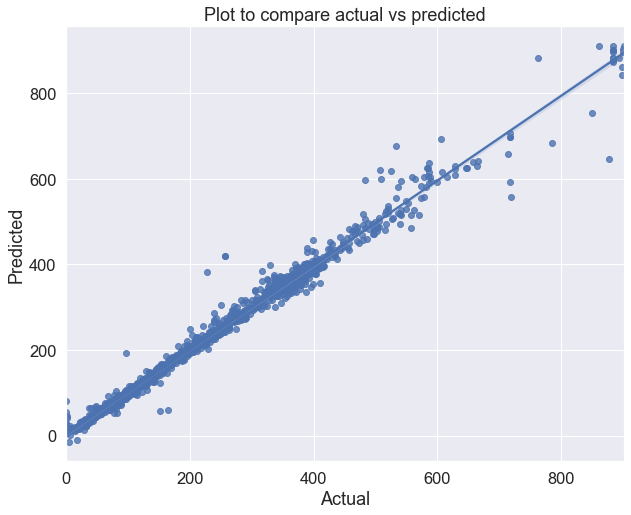

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

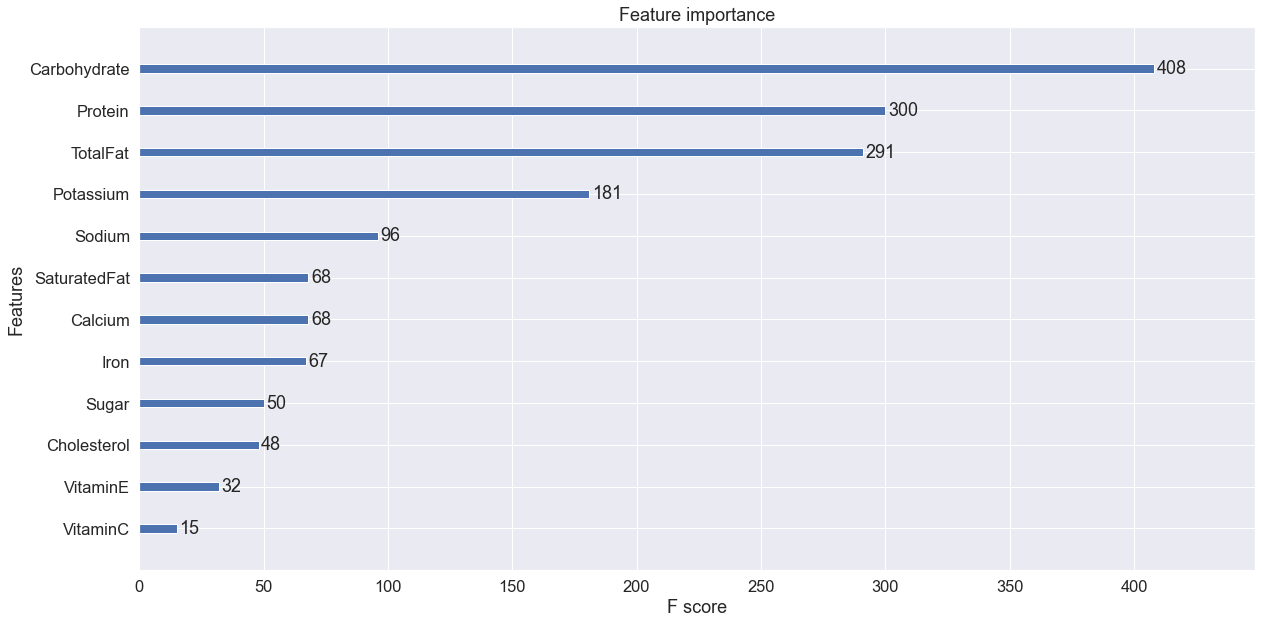

In [57]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgbmodel,ax=ax)
plt.show()

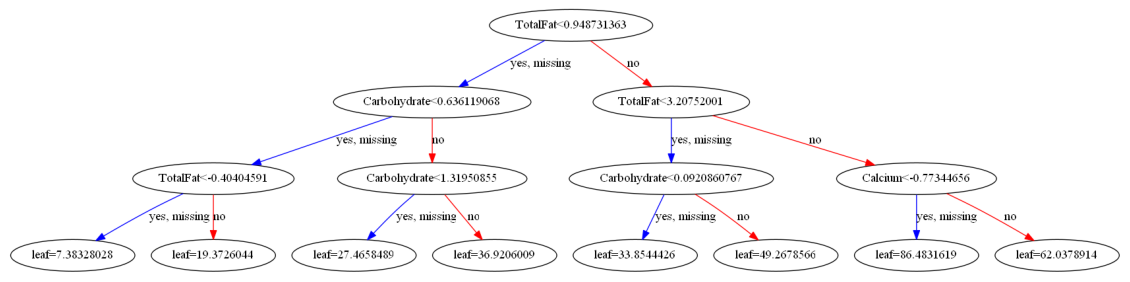

In [60]:
fig, ax = plt.subplots(figsize=(20,20))
plot_tree(xgbmodel,ax=ax)
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [61]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


In [62]:
cv.mean()

0.9760180238990452